In [24]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [25]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+5))+10
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 300*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [26]:
X = []
Y = []
D = 0.01 #almost no diffusion
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

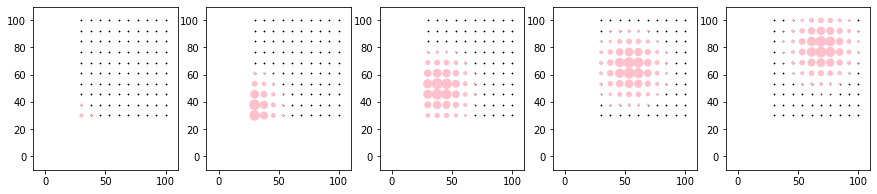

In [27]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [28]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [29]:
#set up our model...
N_feat = 500 #Number of features used to infer the source
k = EQ(20, 1)
res = [250,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

In [ ]:
mInfer.computeModelRegressors(Nparticles=30) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


In [ ]:
concmean,concvar = mInfer.computeConcentration(meanZ,covZ,mInfer.coords[:,::5,::2,::2])

In [ ]:
gridps = mInfer.coords.transpose([1,2,3,0]).copy()
realconc = np.zeros(mInfer.coords.shape[1:])
for i in np.ndindex(gridps.shape[:3]):
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

In [ ]:
 gridX = mInfer.getGridCoord(X[:,1:])/np.array([5,2,2])

for tsamp in range(8):
    plt.figure(figsize=[12,4])
    plt.title(tsamp)
    plt.subplot(1,3,1)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(concmean[tsamp,:,:])
    plt.clim([-5,5])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    plt.clim([0,0.25])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp,:,:])    
    plt.clim([-5,5])
    plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #